In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import SplineTransformer, MinMaxScaler

**Eduson**

In [ ]:
# TODO START
X, Y = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())
print(X_train.shape, X_test.shape)

In [ ]:

num_features = X.shape[1]
for i in range(num_features):
    column = X.columns[i]
    X_train[f"{column}_squared"] = X_train[column] ** 2
    X_test[f"{column}_squared"] = X_test[column] ** 2
    X_train[f"{column}_cubed"] = X_train[column] ** 3
    X_test[f"{column}_cubed"] = X_test[column] ** 3
    X_train[f"{column}_log"] = np.log(10 + X_train[column])
    X_test[f"{column}_log"] = np.log(10 + X_test[column])

    for j in range(i + 1, num_features):
        other_column = X.columns[j]
        X_train[f"{column}_x_{other_column}"] = X_train[column] * X_train[other_column]
        X_test[f"{column}_x_{other_column}"] = X_test[column] * X_test[other_column]

print(X_train.shape, X_test.shape)
print(X_train.columns)
print(X_test.columns)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

print(f"Train MSE: {metrics.mean_squared_error(Y_train, model.predict(X_train)):.3}")
print(f"Test MSE: {metrics.mean_squared_error(Y_test, model.predict(X_test)):.3}")


**Histogram & Scatter**

In [ ]:
# TODO Histogram & Scatter
Y.name
X.columns

**Логорифмическое масштабирование**

In [ ]:
X_log = np.log1p(X.AveOccup)
X_log.describe()

print(X.AveOccup.describe())
print(X_log.describe())

**log1p**, **xlim** - Разжимаем график `log scaling`
* `log1p` - `сжимает` большие значения и `растягивает` маленькие.
    * Функция `log1p(x) = log(x + 1)` безопасна для нулей (а `обычный log(x) не работает`, если `x = 0`).
* `plt.xlim(0, 15)` - визуальный фильтр оси X
    * Это удобно, если выбросы сильно искажают график, а ты хочешь показать «тело» распределения.

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(np.log1p(X.AveRooms), stat="probability")
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(X.AveRooms, stat="probability")
plt.xlim(0, 15)  # Например, игнорировать огромные значения
plt.show()

In [ ]:
# 'MedHouseVal'
# Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude'],
 #     dtype='object')

**Scatterplot feature & target**

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
x_log = np.log1p(X.MedInc)
sns.scatterplot(data=X, x=x_log, y=Y, s=10)

**Регрессионный анализ scipy.stats**
* `p_value` для `slope` / `coef` / `wight`

In [ ]:
# TODO Регрессионный анализ scipy.stats
for column in X_train.columns: 
    feature = X_train[column]
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, Y_train)
    
    print(f'{column} p_value : {p_value}')

    
# print(slope)
# print(intercept)
# print(r_value,)
# print(p_value)
# print(std_err)



**VIF**
* VIF (фактор инфляции дисперсии) — это статистика, которая измеряет уровень `мультиколлинеарности` между `признаками` в `регрессионной модели`.

* Учитывает корреляцию `всех признаков`, в отличии от `корр. матрицы` которая показывает только `парную корреляцию` 
    * VIF смотрит один признак против всех остальных.
    * Корреляционная матрица смотрит пары признаков.
VIF	Интерпретация
* `1`	Нет корреляции между данным признаком и другими
* `1–5`	Умеренная корреляция, приемлемо
* `5–10`	Высокая корреляция, нужно насторожиться
* `> 10`	Очень высокая мультиколлинеарность — признак мешает модели

In [ ]:
# TODO VIF
X_vif = add_constant(X) # добавляем константу (intercept)
type(X_vif)

vif_data = pd.DataFrame() # Пустой DataFrame

vif_data['feature_vif'] = X_vif.columns # Записываем имена столбцов в колонку VIF

vif_data

vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data

**SplineTransformer + Ridge в пайплайне**

In [2]:
# TODO X, Y
X, Y = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape)

(18576, 8) (2064, 8)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train= pd.DataFrame(scaler.transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform( X_test), columns=scaler.get_feature_names_out())

**Эксперемент с MinMaxScaler для визуализации базисных функций**

In [3]:

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train= pd.DataFrame(mm_scaler.transform(X_train), columns=mm_scaler.get_feature_names_out())
X_test = pd.DataFrame(mm_scaler.transform( X_test), columns=mm_scaler.get_feature_names_out())

# pipeline SplineTransformer


**Параметры	SplineTransformer** 
* `degree=3`	Кубические сплайны
* `n_knots=5`	Количество узлов ⇒ определяет гибкость (как много кусочков у кривой)
* `include_bias=False`	Убирает константу, если она уже есть в модели

In [ ]:
# TODO SplineTransformer Обучение на california_housing


# Пайплайн: сначала сплайны, потом линейная модель
model = make_pipeline(
    SplineTransformer(degree=3, n_knots=5, include_bias=False),
    Ridge(alpha=10)
)

# Обучение на california_housing
model.fit(X_train, Y_train)

# Оценка
y_pred = model.predict(X_test)
print(f"MSE: {mean_squared_error(Y_test, y_pred):.3f}")





In [ ]:
# 'MedHouseVal'
# Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude'],
 #     dtype='object')

# MY

**SplineTransformer без pipeline**

0.5232007943970398
всего признаков после трансформации : 48
было исходных признаков : 8
Базисных функций на один признак: 6


Text(0.5, 1.02, 'Базисные функции сплайнов для всех признаков')

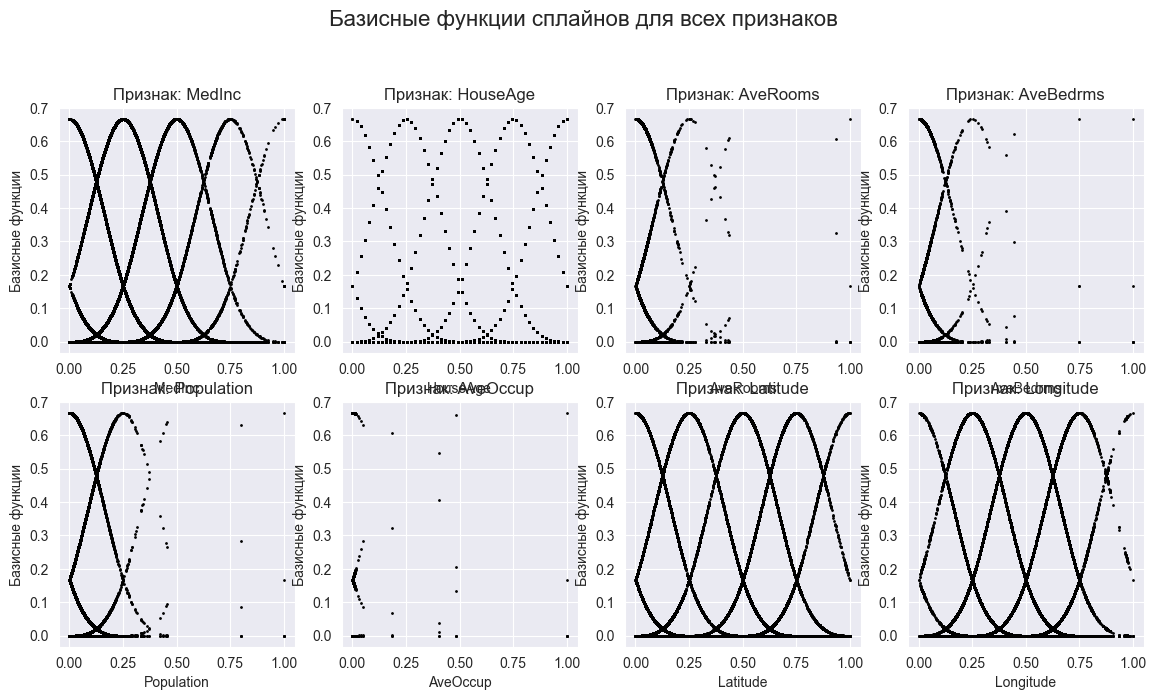

In [4]:
# TODO SplineTransformer без pipeline

__doc__ = '''
nrows=2, ncols=4 -> 2-х мерный контейнер, Матрица осей 2 х 4
axes = axes.ravel() -  Выпрямление матрицы Осей, Преобразуем в 1-мерный контейнер 2 х 8
'''

spline = SplineTransformer(degree=3, n_knots=5, include_bias=False)

X_train_spline = spline.fit_transform(X_train) # (n_samples, n_basis)
X_test_spline = spline.transform(X_test)

model = Ridge(alpha=10)

model.fit(X_train_spline, Y_train)
Y_pred = model.predict(X_test_spline)

print(metrics.mean_squared_error(Y_test, Y_pred))

# Задаём параметры для построения базисных функций
n_basis_total = spline.n_features_out_       # всего признаков после трансформации
n_features_in = spline.n_features_in_        # было исходных признаков
n_basis_per_feature = n_basis_total // n_features_in  # базисных функций на один признак

print(f'всего признаков после трансформации : {n_basis_total}')
print(f'было исходных признаков : {n_features_in}')
print(f"Базисных функций на один признак: {n_basis_per_feature}")

col = X_train.columns
start = 0
stop = n_basis_total  # 48
step = n_basis_per_feature  # 6

# Визуализируем базисные функции сплайнов
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))
axes = axes.ravel()  # Преобразуем в 1-мерный объект
for n, i in enumerate(range(start, stop, step )):  # индекс начала нового отрезка 
    
    for j in range(i, i + step):
        label=f'Базис {col[n]}'
        # print(col[n], j)
        axes[n].plot(X_train[col[n]], X_train_spline[:, j], 'ko', markersize=1, label=label)
        axes[n].set_title(f"Признак: {col[n]}")
        axes[n].set_xlabel(col[n])
        axes[n].set_ylabel("Базисные функции")
        # axes[n].legend()  # ← добавь это
plt.suptitle("Базисные функции сплайнов для всех признаков", fontsize=16, y=1.02)



# Eduson

In [ ]:
# Параметры
col = X_train.columns
n_features = n_features_in
n_basis = n_basis_per_feature

# Создаём сетку подграфиков
fig, axes = plt.subplots(nrows=2, ncols=(n_features + 1) // 2, figsize=(15, 8))
axes = axes.ravel()

for feature_idx in range(n_features):
    start = feature_idx * n_basis
    stop = start + n_basis
    
    x = X_train.iloc[:, feature_idx].values.reshape(-1, 1)
    
    ax = axes[feature_idx]
    for j in range(start, stop):
        ax.plot(x, X_train_spline[:, j], 'ko', markersize=2, lw=1)
        
    ax.set_title(f"Признак: {col[feature_idx]}")
    ax.set_xlabel(col[feature_idx])
    ax.set_ylabel("Базисные функции")

plt.tight_layout()
plt.suptitle("Базисные функции сплайнов для всех признаков", fontsize=16, y=1.02)
plt.show()


In [ ]:
 # TODO работа SplineTransformer на одном числовом признаке.

# Исходные данные — числовой признак
X = np.linspace(0, 10, 100).reshape(-1, 1)

# Создаём трансформер: кубический сплайн с 5 узлами, без bias
spline = SplineTransformer(degree=3, n_knots=5, include_bias=False)

# Применяем трансформацию
X_spline = spline.fit_transform(X)
print(X_spline.shape)
print(X_spline[:2])

# Визуализируем базисные функции сплайнов
plt.figure(figsize=(5, 3))
for i in range(X_spline.shape[1]):
    plt.plot(X, X_spline[:, i], label=f'Базис {i+1}')
plt.title('Базисные функции SplineTransformer (degree=3, n_knots=5)')
plt.xlabel('X')
plt.ylabel('Значение базисной функции')
plt.legend()
plt.show()

**pd.cut & pd.qcut** + группировка по элементам

In [ ]:
# 'MedHouseVal'
# Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude'],
#     dtype='object')

In [ ]:
X.MedInc.describe()

In [ ]:

# TODO pd.cut & pd.qcut & kde & scatterplot & histplot & boxplot
X_cut = pd.cut(X.MedInc, bins=[3, 7, 11, 15], labels=['One', 'Two', 'Three'])

print(X_cut.value_counts())

X_qcut = pd.qcut(X.MedInc, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

X_qcut.value_counts()

**Распределение целевой по элементам признака**

In [ ]:
# TODO Распределение целевой по элементам признака

# Объединить X_qcut и y в один DataFrame
df_temp = pd.DataFrame({'IncomeGroup': X_qcut, 'HouseVal': Y})

plt.figure(figsize=(4, 4))
sns.boxplot(data=df_temp, x='IncomeGroup', y='HouseVal', order=['Q4', 'Q3', 'Q2', 'Q1'])
plt.title('Распределение MedHouseVal по квартилям MedInc')
plt.show()

In [ ]:
df_temp.describe(include='all')

**Стоимость домов в разрезе доходов MedInc**
* `IncomeGroup` - разделёный на группы признак MedInc
* `hue='IncomeGroup'` — разделение по квартилям.

* `element='step'` — аккуратные контуры (альтернатива: 'bars').

* `stat='density' `— нормализованная плотность (можно заменить на 'count').

* ` common_norm=False` — позволяет сравнивать плотности по отдельности для каждого квартиля.



In [ ]:
sns.histplot(data=df_temp, x='HouseVal', hue='IncomeGroup',element='step', stat='density', common_norm=False)

**kde**

In [ ]:
sns.kdeplot(data=df_temp, x='HouseVal', hue='IncomeGroup', common_norm=False)

**Графики с panas**
* Гистограмма распределения MedHouseVal по  категориям MedInc 

In [ ]:
# TODO распределение MedHouseVal по  категориям MedInc

# 'MedHouseVal'
# Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude'],
#     dtype='object')

'''
'IncomeGroup' - разбитый на категории по квантилям признак 'MedInc'
'HouseVal' - целевая 'MedHouseVal'
'''

grp_sum = df_temp.groupby(['IncomeGroup'])['HouseVal'].sum()

grp_sum.plot(kind='bar', stacked=True, figsize=(3, 3))


**sns.pairplot**

In [ ]:
# tODO sns.pairplot

X['target'] = Y

X.columns
# Y.shape
print(X.shape)

# sns.pairplot(np.log1p(X[['target', 'MedInc', 'AveBedrms']]))

sns.pairplot(X, vars=['target', 'MedInc'])


**kaggle**

In [ ]:
Y.describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
X['MedInc'].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
# 'MedHouseVal'
# Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
#       'Latitude', 'Longitude'],
#     dtype='object')

In [ ]:
X = datasets.fetch_california_housing(as_frame=True, return_X_y=False)

np.log1p(X['frame'] + 125)